#Cбор данных

Рассмотрим сайт  http://fontanka.ru. На данном сайте нас интересует архив <a href =  'http://www.fontanka.ru/fontanka/arc/2015/all.html'>новостей</a> за 2015 год. Получим ссылки на каждый день 2015 года и сохраним в отдельный файл.

In [1]:
# необходимые пакеты 
import lxml.html
import requests
import codecs
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [52]:
#получим страницу с архивом за январь
path = "http://www.fontanka.ru/fontanka/arc/2015/all.html"
response = requests.get(path)
if response.status_code == 200:
    html = response.content
    tree = lxml.html.document_fromstring(html)
    
    links = tree.xpath("""//div[@class='calendar-inner']/table[@class='blank_year']//tr/td[@class='blank_monthcell']
        /table/tbody/tr/td[@class='dom']/a/@href""")
    with open('fontanka-year2015-links', 'w') as ouf:
        for link in links:
            ouf.write("http://fontanka.ru%s\n"%(link))

Теперь имеются ссылки на архив новостей на каждый день 2015 года. Нужно перейти по каждой ссылке на соответствующую страницу. На этой странице скачать ссылки на новости. <br>
Каждая новость имеют категорию. Будем учитывать это.

In [164]:
with codecs.open('news_category_links', 'w', encoding="utf8") as ouf:
    with open('fontanka-year2015-links', 'r') as inf:
        summ = 0
        for link in inf:
            print link.strip(),
            response = requests.get(link)
            if response.status_code == 200:
                html = response.content
                tree = lxml.html.document_fromstring(html)

                links = tree.xpath('''/html/body/div[@class="wrapper clearfix"]/div[@class="main-col 
                clearfix"]/div[@class="big_center ml30 fll"]/div[@class="calendar-widget"]
                /div[@class="calendar-inner transition open"]/div[@class="calendar-list"]/div
                [@class="calendar-item"]/div[@class="calendar-item-title"]/a''')
                print len(links),
                summ += len(links)
                print summ
                for l in links:
                    link = l.attrib['href']
                    if link[0] != "/":
                        continue
                    category = l.getnext().getchildren()[0].text_content()
                    
                    ouf.write("%s\t%s\n" % (category, link))          

http://fontanka.ru/fontanka/2015/01/01/all.html 66 66
http://fontanka.ru/fontanka/2015/01/02/all.html 49 115
http://fontanka.ru/fontanka/2015/01/03/all.html 84 199
http://fontanka.ru/fontanka/2015/01/04/all.html 60 259
http://fontanka.ru/fontanka/2015/01/05/all.html 55 314
http://fontanka.ru/fontanka/2015/01/06/all.html 49 363
http://fontanka.ru/fontanka/2015/01/07/all.html 97 460
http://fontanka.ru/fontanka/2015/01/08/all.html 90 550
http://fontanka.ru/fontanka/2015/01/09/all.html 98 648
http://fontanka.ru/fontanka/2015/01/10/all.html 89 737
http://fontanka.ru/fontanka/2015/01/11/all.html 103 840
http://fontanka.ru/fontanka/2015/01/12/all.html 178 1018
http://fontanka.ru/fontanka/2015/01/13/all.html 185 1203
http://fontanka.ru/fontanka/2015/01/14/all.html 180 1383
http://fontanka.ru/fontanka/2015/01/15/all.html 206 1589
http://fontanka.ru/fontanka/2015/01/16/all.html 215 1804
http://fontanka.ru/fontanka/2015/01/17/all.html 98 1902
http://fontanka.ru/fontanka/2015/01/18/all.html 78 198

Осталось скачать сами новости.

In [2]:
main_path = u"http://www.fontanka.ru"
path_for_saving_news = u'./all_news/'
number_of_news_downloaded = 0

cnt = 0
threshold = 47121
with codecs.open('news_category_links', 'r', encoding='utf8') as inf:
    for line in inf:
        cnt += 1
        print cnt, 
        if cnt < threshold:
            continue
	
        category, link = line.split('\t')
        link = link.strip()
        try:
            response = requests.get(main_path + link)
        except:
            print "Something bad (no response) with %s"%link
            continue
        
        if category not in os.listdir(path_for_saving_news):
            os.mkdir(path_for_saving_news + category)
        
        path_for_news = path_for_saving_news[2:] + category + '/'
        
        if response.status_code == 200:
            
            try:
                number_of_news_downloaded += 1
                html = response.content
                tree = lxml.html.document_fromstring(html)
                txt = tree.xpath("""//div[@class='article']/div[@class='article_desc']
                /div[@class='article_fulltext']/p/text()""")
                filename = link.replace("/", "_")
                with codecs.open(path_for_news+filename, 'w', encoding="utf8") as ouf:
                    for t in txt:
                        ouf.write(t)
            except:
                print "Something bad with %s"%link
                    
        else:
            print "Something bad with %s"%link
        if (number_of_news_downloaded + threshold) % 10 == 1:
            print "%d \n"%(number_of_news_downloaded + threshold), 
            time.sleep(0.5)

Загрузилось около 47 тысяч статей. <br>
Но среди полученных файлов есть пустые файлы (статьи), так как иногда ссылки вели на сторонние сайты. Избавимся от этого мусора. Также удалим папки в которых менее 100 статей.

In [36]:
path_with_news = './all_news/'
for d in os.listdir(path_with_news):
    path = path_with_news + d
    nFilesInDir = 0
    nDeletedFilesInDir = 0
    if os.path.isdir(path):
        print "Папка: '%s'"%d
        
        for f in os.listdir(path):
            filePath = path + '/' + f
            if os.path.getsize(filePath) < 100:
                nDeletedFilesInDir += 1
                os.remove(filePath)
            else:
                nFilesInDir += 1
    print "\tКоличество хороших файлов: %d, количество удаленных файлов: %d"%(nFilesInDir, nDeletedFilesInDir)
    if nFilesInDir < 100 :
        res = "Папка удалена"
        shutil.rmtree(path)
    else:
        res = "Папка оставлена"
    print "\tРезультат: %s"%res

Папка: 'Водитель Петербурга Live'
	Количество хороших файлов: 4, количество удаленных файлов: 0
	Результат: Папка удалена
Папка: 'Веселые старты'
	Количество хороших файлов: 0, количество удаленных файлов: 14
	Результат: Папка удалена
Папка: 'Антон Мухин'
	Количество хороших файлов: 0, количество удаленных файлов: 6
	Результат: Папка удалена
Папка: 'Власть'
	Количество хороших файлов: 5539, количество удаленных файлов: 49
	Результат: Папка оставлена
Папка: 'Расскажи о солдате'
	Количество хороших файлов: 2, количество удаленных файлов: 0
	Результат: Папка удалена
Папка: 'Евгений Зеленев'
	Количество хороших файлов: 0, количество удаленных файлов: 3
	Результат: Папка удалена
Папка: 'БеспринцЫпный клуб'
	Количество хороших файлов: 0, количество удаленных файлов: 10
	Результат: Папка удалена
Папка: 'Очевидец'
	Количество хороших файлов: 2, количество удаленных файлов: 0
	Результат: Папка удалена
Папка: 'Александр Цыпкин'
	Количество хороших файлов: 0, количество удаленных файлов: 1
	Резул

Посмотрим какие темы остались

In [107]:
path_with_news = './all_news/'
ourTopics = {}
for d in os.listdir(path_with_news):
    ourTopics[d.decode('utf-8')] = len(os.listdir(path_with_news + d))

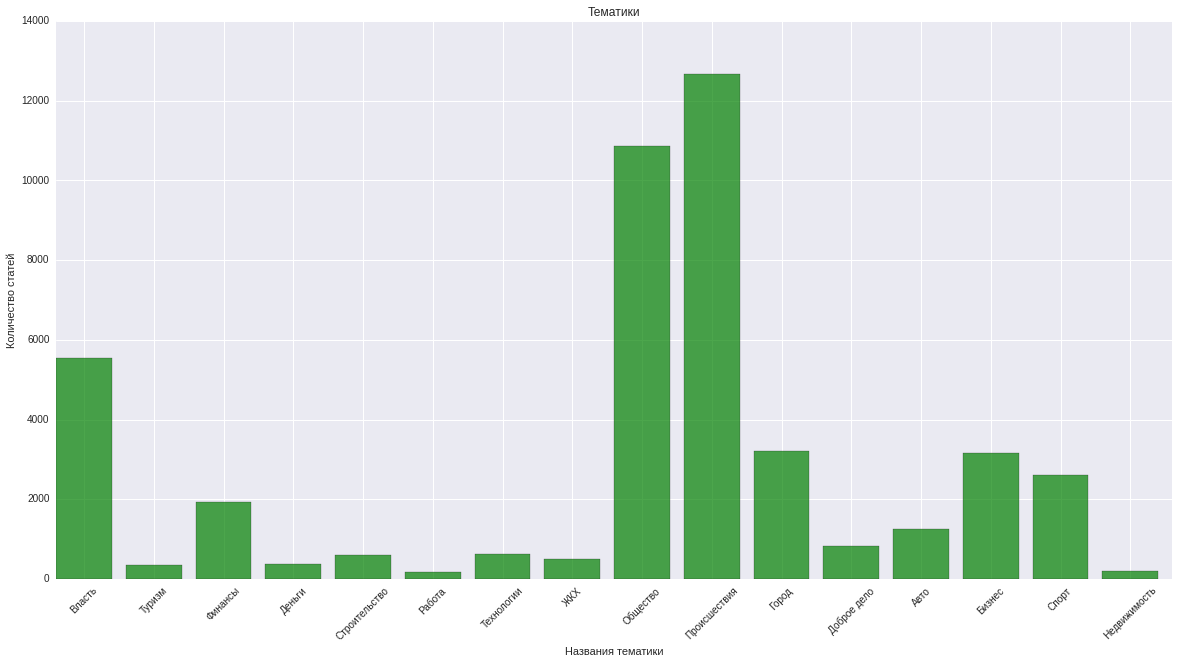

In [108]:
plt.figure(figsize=(20,10))
ind = np.arange(len(ourTopics.items()))
plt.bar(ind, ourTopics.values(), color='g', alpha = 0.7)

plt.title(u'Тематики')
plt.ylabel(u'Количество статей')
plt.xlabel(u'Названия тематики')
plt.xticks(ind + 0.4, tuple(ourTopics.keys()), rotation = 45)
pass

# Предобработка данных

Обработаем каждую из статей. Для каждой из статей возьмем текст и разобьем его по пробелу. Получим "слова", которые могут содержать знаки пунктуации, цифры. Выделим среди них "хорошие слова", которые будут характеризовать текст. Каждое "хорошее слово" приведем к нижнему регистру и найдем его лемму с помощью PyMorpy2. Также исключим стоп-слова (стоп слова взяти из пакетов nltk.stopwords и stop_words). Постараемся выделить аббревиатуры.

<br> <i> можно попробовать pymystem3 для лемматизации </i> 

Получим список стоп-слов. Зададим недопустимые знаки. Создадим морфологический анализатор.
Реализуем вспомогательные функции для обработки текстовой строки, обработки слова.

In [222]:
from nltk.corpus import stopwords
import stop_words
import pymorphy2
import re
import codecs

stops = getStopWords()
forStrip = "".join(['.',',','!','?','"',"'",';',':','-',u'«',u'»'])
morph = pymorphy2.MorphAnalyzer()

def getStopWords():
    mystopwords = set(stopwords.words("russian"))
    mystopwords = set.union(mystopwords, stop_words.get_stop_words('russian'))
    return mystopwords

def relax_word(word, prev_word = None):
    """Обработка слова. Приведение к нормальному виду"""
    if len(word) < 2:
        return None
    
    # Удаление слов, в которых есть цифры (лучше считать отношение количества цифр к количеству букв)
    if re.search(r'\d', word):
        return None
    
    # Удаление знаков препинания и других символов с обеих концов строки
    word = word.strip(forStrip)
    
    # выделение аббревиатур
    if word.isupper() and len(word) > 1 and len(word) < 7:
        return word.lower()
    
    # Приведение к нижнему регистру
    word = word.lower()
    
    # Удаление стоп-слов
    if word in stops:
        return None
        
    # Лемматизация с помощью pymorpy2
    word = morph.parse(word)[0].normal_form
    
    return word

def prepocess(text):
    """ Функция получает строку текста и делает его преодработку """
    text = text.split()
    result = []
    for word in text:
        word = relax_word(word)
        if word:
            result.append(word)
    return " ".join(result)
    
    

Рассмотрим пример обработки строки: **В 10:32 на пульт дежурного "01" поступило сообщение о ДТП в Красногвардейском районе, сообщает сайт ГУ МЧС по Петербургу. Читатель "Фонтанки" между тем сообщил, что на углу проспектов Ударников и Индустриального лежит перевернутый автобус.**

In [223]:
test_string = u"""В 10:32 на пульт дежурного "01" поступило сообщение о ДТП в Красногвардейском районе, 
сообщает сайт ГУ МЧС по Петербургу. Читатель "Фонтанки" между 
тем сообщил, что на углу проспектов Ударников и Индустриального лежит перевернутый автобус."""

print prepocess(test_string)

пульт дежурный поступить сообщение дтп красногвардейский район сообщать сайт гу мчс петербург читатель фонтанка сообщить угол проспект ударник индустриальный лежать перевернуть автобус


###Предобработка всей коллекции

In [212]:
news_path = "./all_news/"
preprocessedNews_path = "./preprocessedNews/"

news_category = os.listdir(news_path)
for nc in os.listdir(news_path):
    try:
        os.mkdir(preprocessedNews_path + nc)
    except:
        pass

In [227]:
for newsCat in os.listdir(news_path):
    print "Processed: %s\n"%newsCat
    for article in os.listdir(news_path + newsCat):
        with codecs.open(preprocessedNews_path + newsCat + '/' + article, 'w', 'utf8') as ouf:
            with codecs.open(news_path + newsCat + '/' + article, 'r', 'utf8') as inf:
                for line in inf:
                    if len(line) > 3:
                        ouf.write("%s "%prepocess(line))

Processed: Власть

Processed: Технологии

Processed: Происшествия

Processed: Строительство

Processed: Деньги

Processed: Работа

Processed: Недвижимость

Processed: Туризм

Processed: ЖКХ

Processed: Общество

Processed: Авто

Processed: Финансы

Processed: Спорт

Processed: Город

Processed: Бизнес

Processed: Доброе дело



### Подготовка данных для LDA

Выберем нужные нам темы и необходимое число статей для каждой темы. Словарь dataOption в качестве ключей хранит название темы, а в качестве значений число статей для соответствующей темы.

In [109]:
dataOption = {u'Технологии' : 200, u'Авто':200, u'Бизнес':200, u'Спорт':200 }

In [110]:
from collections import defaultdict

wordToId = {}
idToDoc = {}

# docid : (nWords, [wordId])
docs = defaultdict(lambda : [])


last_wordid = -1
last_docid = -1

path = "./preprocessedNews/"

for topicName,nArticle in dataOption.items():
    list_articles = os.listdir(path + topicName)
    np.random.shuffle(list_articles)
    for article in list_articles[:nArticle]: 
        # Создадим id для статьи
        last_docid += 1
        idToDoc[last_docid] = topicName + '/' + article
        
        # Обработка статьи
        with codecs.open(path + topicName + '/' + article, 'r', 'utf8') as inf:
            for line in inf:
                for w in line.split():
                    if w not in wordToId.keys():
                        last_wordid += 1
                        wordToId[w] = last_wordid
                    docs[last_docid].append(str(wordToId[w]))
    print "%s done"%topicName                        

Бизнес done
Спорт done
Авто done
Технологии done


In [112]:
import json
name_of_corpus = "Corpus2"
try:
    os.mkdir(name_of_corpus) 
    corpus_path = "./%s/"%name_of_corpus

    json.dump(dataOption, codecs.open(corpus_path + "topicinfo.json", 'w', 'utf8'))
    #json.dump(wordToId, codecs.open(corpus_path + "wordid.json", 'w', 'utf8'))
    json.dump(idToDoc, codecs.open(corpus_path + "docid.json", 'w', 'utf8'))
    #json.dump(invertedIndex, codecs.open(corpus_path + "invertedIndex.json", 'w', 'utf8'))  
    with open(corpus_path + 'docs.lda', 'w') as ouf:
        for docid, wids in docs.items():
            ouf.write('%d\t%s\n'%(docid, " ".join(wids)))
    
        
    with codecs.open(corpus_path + 'vocab.lda', 'w', 'utf8') as ouf:
        for k,v in wordToId.items():
            ouf.write("%d\t%s\n"%(v, k))
            
    #with codecs.open(corpus_path + 'size.info', 'w', 'utf8') as ouf:
        #ouf.write('Words: %d\n'% len(wordToId.keys()))
        #ouf.write('Docs: %d\n'% len(idToDoc.keys()))
    
except:
    print "Что-то пошло не так"
    

<i> не все слова хорошие: примеры:</i> <br>
нет…,данчарова),[длить, информацией»,—

In [113]:
print "Количество слов в словаре: %d" % len(wordToId.keys())
print "Количество документов: %d" % len(idToDoc.keys())

Количество слов в словаре: 15051
Количество документов: 800


# LDA
## Реализация класса LDA


 <img src=smoothed_lda.png>

In [114]:
class LDA(object):
    def __init__(self, corpus_path, K, alpha = 0.1, beta = 0.1):
        self.K = K
        self.alpha = alpha
        self.beta = beta
        
        self.Voc = {}
        self.V = 0
        with codecs.open(corpus_path + 'vocab.lda', 'r', 'utf8') as inf:
            for line in inf:
                wid, word = line.split()
                self.Voc[int(wid)] = word
                self.V += 1
        
        self.docs = []
        self.M = 0
        with codecs.open(corpus_path + 'docs.lda', 'r', 'utf8') as inf:
            for line in inf:
                ##### needfix
                docid, wids = line.split('\t')
                if len(self.docs) != int(docid):
                    print "Ошибка с индексом документа"
                    return
                self.docs.append([int(wid) for wid in wids.split()])
                self.M += 1
        
        self.z_mn = []                                 # тема n-го слова в документе m
        self.n_mz = np.zeros((self.M, self.K)) + alpha # число слов в документе m с темой z
        self.n_zt = np.zeros((self.K, self.V)) + beta  # сколько раз слово t встречается в теме z
        self.n_z  = np.zeros((self.K)) + self.V*beta   # число слов в каждой теме
        
        # смотрим все документы
        for m, doc in enumerate(self.docs):
            # для каждого слова выбираем тему
            z_n = []                           # z_n[i] хранит тему для i-го слова
            
            # смотрим все слова в этом документе, wordid - ид слова, nw - сколько раз слово встречается в документе
            for t in doc:                
                # выбираем тему
                #z = np.random.randint(0, self.K)
                p_z = self.n_zt[:,t] * self.n_mz[m] / self.n_z
                z = np.random.multinomial(1, p_z / p_z.sum()).argmax()

                z_n.append(z)

                # обновляем матрицы
                self.n_mz[m, z]      += 1.0
                self.n_zt[z, t]      += 1.0
                self.n_z[z]          += 1.0
            self.z_mn.append(np.array(z_n))
            
    def iteration(self):
        """Одна итерация"""
        # смотрим все документы
        for m,doc in enumerate(self.docs):
            for n, t in enumerate(doc):
                # выбираем тему
                z = self.z_mn[m][n]
                #print self.n_mz[docid, z], self.n_zt[z, wordid], self.n_z[z]
                self.n_mz[m,z]   -= 1.0
                self.n_zt[z, t] -= 1.0
                self.n_z[z]          -= 1.0
                #print self.n_mz[docid, z], self.n_zt[z, wordid], self.n_z[z]

                #выбриаем новую тему
                p_z = (self.n_zt[:,m]) * (self.n_mz[m]) / (self.n_z)

                #print p_z
                #print p_z.sum()
                new_z = np.random.multinomial(1, p_z / p_z.sum()).argmax()

                self.z_mn[m][n] = new_z
                self.n_mz[m, new_z]      += 1.0
                self.n_zt[new_z, t]      += 1.0
                self.n_z[new_z]          += 1.0

    def get_phi(self):
        return self.n_zt / self.n_z[:, np.newaxis]
    
    def perplexity(self):
        phi = self.get_phi()
        N = 0
        logPerplexity = 0
        
        for m,doc in enumerate(self.docs):
            theta = self.n_mz[m] /(len(doc) + self.K * self.alpha)
            for w in doc:
                logPerplexity -= np.log(np.inner(phi[:,w], theta))
            N += len(doc)
        return np.exp(logPerplexity / N)
    
    
    def learn(self, n_iter):
        last_perplexity = self.perplexity()
        print "Начальное значение perplexity: %f" % last_perplexity
        for i in range(n_iter):
            self.iteration()
            perplexity = self.perplexity()
            print "Итерация %d: perplexity=%f"%(i+1,perplexity)
            if last_perplexity < perplexity:
                print "model is learned"
                return
            last_perplexity = perplexity
        
    def get_wt_distribution(self):
        phi = self.get_phi()
        for i in range(self.K):
            print "\n\ntopic %d"%i
            for w in np.argsort(-phi[i])[:20]:
                print "+ %f*%s"%(phi[i,w], self.Voc[w]),
        
        
        

In [115]:
mylda = LDA('./Corpus1/', K=5, alpha=0.01, beta=0.01)

In [116]:
mylda.learn(50)

Начальное значение perplexity: 3455.808302
Итерация 1: perplexity=3015.533920
Итерация 2: perplexity=2926.665790
Итерация 3: perplexity=2868.243469
Итерация 4: perplexity=2830.103062
Итерация 5: perplexity=2834.129910
model is learned


In [118]:
print "Были даны темы: "
for topic in dataOption.keys():
    print topic,
mylda.get_wt_distribution()

Были даны темы: 
Бизнес Спорт Авто Технологии 

topic 0
+ 0.006857*россия + 0.004011*матч + 0.003882*один + 0.003752*рубль + 0.003623*фонтанка + 0.003235*зенит + 0.003235*сообщать + 0.003235*компания + 0.003106*стать + 0.003106*место + 0.002847*данные + 0.002847*петербург + 0.002588*сообщить + 0.002588*проект + 0.002459*игра + 0.002459*район + 0.002330*работа + 0.002330*дело + 0.002330*информация + 0.002330*слово 

topic 1
+ 0.007298*россия + 0.004676*компания + 0.004334*российский + 0.003535*сообщать + 0.003193*решение + 0.003193*страна + 0.003193*рубль + 0.002851*сообщить + 0.002851*суд + 0.002851*украина + 0.002851*дело + 0.002737*стать + 0.002623*слово + 0.002623*матч + 0.002623*заявить + 0.002395*находиться + 0.002395*выбор + 0.002395*ранее + 0.002395*фонтанка + 0.002281*миллиард 

topic 2
+ 0.009890*компания + 0.006701*россия + 0.004270*цена + 0.003999*рубль + 0.003729*миллион + 0.003567*российский + 0.003351*украина + 0.003297*петербург + 0.003189*один + 0.003135*поезд + 0.00286